In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
import time
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn import metrics
import seaborn as sn
import pygame
import time
import cv2
from PIL import Image
from pygame.locals import K_ESCAPE, KEYDOWN
from resizeimage import resizeimage
from random import choice
import tensorflow as tf

In [14]:
import tensorflow as tf
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

print(f"""shapes:
X_train:{X_train.shape}
y_train:{y_train.shape}
X_test:{X_test.shape}
y_test:{y_test.shape}""")


shapes:
X_train:(60000, 28, 28)
y_train:(60000,)
X_test:(10000, 28, 28)
y_test:(10000,)



Each X data is a 28*28 matrix whose entries correspond to the grayscale color of the pixels in the digit image. Let's convert the data back to the digit image.

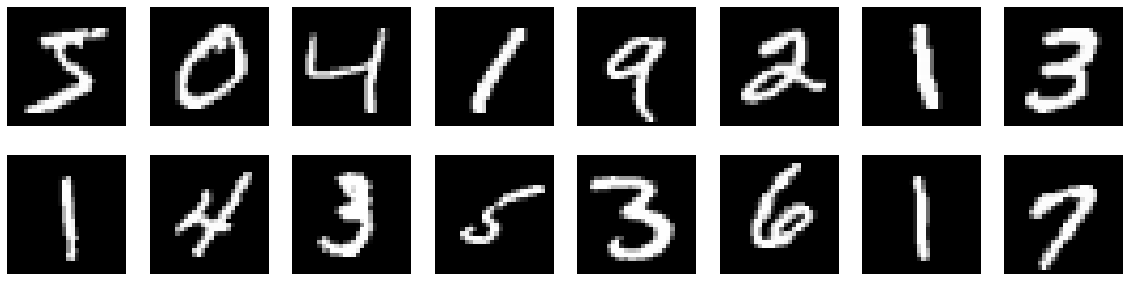

In [19]:
def display(data):
    fig = plt.figure(figsize=(20, 5))
    c = 8
    r = 2
    for i in range(c*r):
        fig.add_subplot(r, c, i+1)
        plt.axis('off')
        plt.imshow(data[i],cmap='gray') # convert the vector back to matrix
    plt.show()
 
display(X_train)

By using the <sub>shrunken</sub> trick mentioned in the README, we can create the __Shrunken__ version of the original dataset.

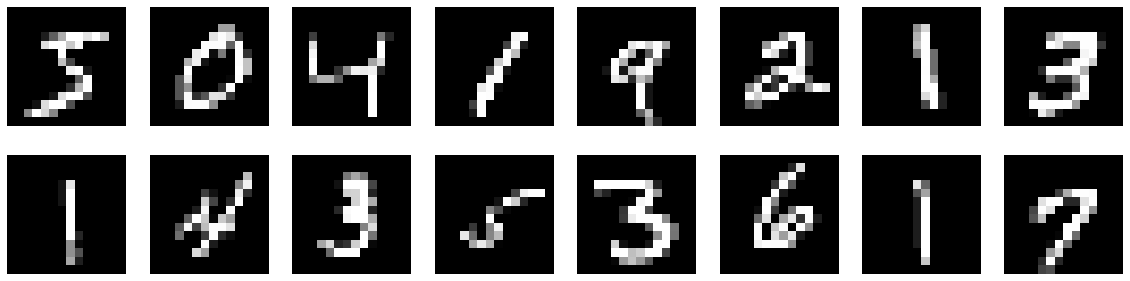

In [20]:
def shrunken(data):
    idx = range(0, 28, 2)
    data = data[idx]
    data = data.transpose()[idx]
    data = data.transpose()
    return data
 
display([shrunken(data) for data in X_train[0:16]])

We can even standardize the __Shrunken__ dataset as we might want a faster convergence in svm and logistic regression.

In [21]:
# convert data matrices into one-dimensional vectors
X_train_shrunken = np.array([shrunken(data) for data in X_train])
X_train_shrunken = np.reshape(X_train_shrunken, (60000, 196))
X_test_shrunken = np.array([shrunken(data) for data in X_test])
X_test_shrunken = np.reshape(X_test_shrunken, (10000, 196))


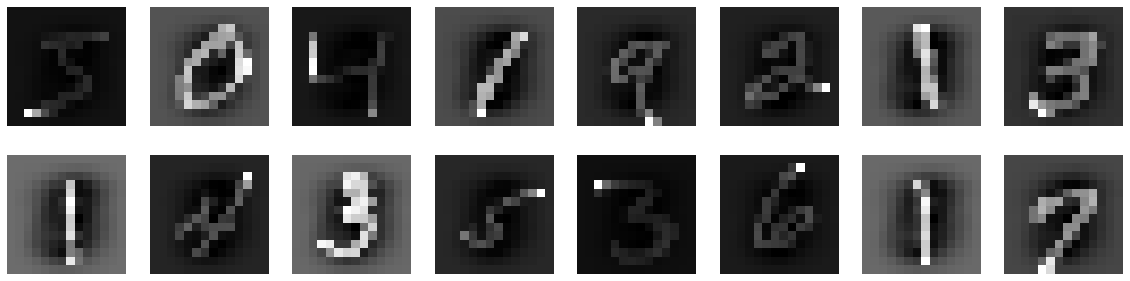

In [22]:
def standardize(X):
    scaler = preprocessing.StandardScaler().fit(X)
    X_scaled = scaler.transform(X)
    return X_scaled

X_train_shrunken_scaled = standardize(X_train_shrunken)
X_test_shrunken_scaled = standardize(X_test_shrunken)
display(np.reshape(X_train_shrunken_scaled, (60000,14,14)))

In [8]:

X_train = np.reshape(X_train, (60000, 784))
X_test = np.reshape(X_test, (10000, 784))


DIY KNN:

Good exercise for coding, but super slow due to inferior implementation, unusable for large dataset and CV & parameter tuning. Will use scikit-learn instead.

In [32]:

# from statistics import mode

# # get the Euclidean distance between two data
# def get_distance(a, b): # inputs are vectors, i.e. 1-d array in numpy
#     gap = a-b
#     distance = sum([x**2 for x in gap])**0.5
#     return distance

# def get_sorted_distance(X_train, X_test, y_train):
#     d_matrix = [] 
#     for i in range(len(X_test)):
#         d_row = [] # each entry is a distance
#         for j in range(len(X_train)):
#             d = get_distance(X_train[j], X_test[i])
#             d_row.append(d)
#         d_matrix.append(d_row) # each row contains distances from all train data for a test data
#     return d_matrix

# def predict_with_k(d_matrix, k):
#     preds = [] # each entry is a prediction for a test data
#     for i in range(len(d_matrix)):
#         idx = np.argsort(d_matrix[i])[:k] # get the index for the nearest k train data
#         neighbor = [y_train[each_idx] for each_idx in idx] # get the label of the nearest k train data
#         try:
#             pred = mode(neighbor) # this block is for the case where there is a tie
#         except:
#             pred = neighbor[0] # if there is a tie, it doesn't matter which one to pick
#         preds.append (pred)
#     return preds


The following is a comparison between using the orignal data and the __shrunken__ data in terms of accuracy and time.

In [9]:
k_values = [1,3,5,10,20,50]

def using_KNN(X_train, X_test):
    accuracy = []
    time_elapsed = []
    for k in k_values:
        tick = time.process_time()
        neigh = KNeighborsClassifier(n_neighbors = k)
        neigh.fit(X_train, y_train)
        each_accuracy = neigh.score(X_test, y_test)
        tock = time.process_time()
        accuracy.append(each_accuracy)
        each_time = tock - tick
        time_elapsed.append(each_time)
    return accuracy, time_elapsed

accuracy_original, time_original = using_KNN(X_train,  X_test)
accuracy_shrunken, time_shrunken = using_KNN(X_train_shrunken, X_test_shrunken)

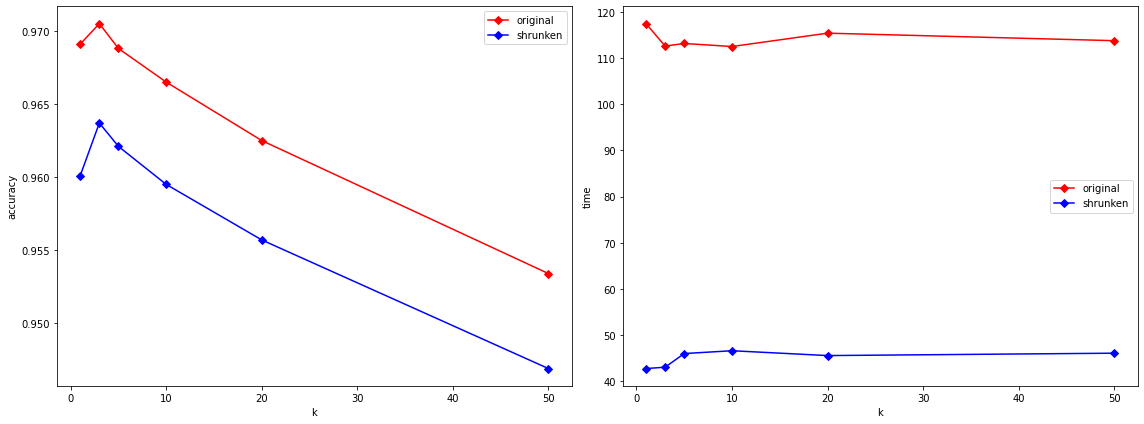

In [10]:

fig = plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
[original, shrunken] = plt.plot(k_values, accuracy_original, 'rD-', k_values, accuracy_shrunken, 'bD-')
plt.xlabel('k')
plt.ylabel('accuracy')
plt.legend([original, shrunken], ['original', 'shrunken'], loc = 'upper right')
plt.subplot(1,2,2)
[original, shrunken] = plt.plot(k_values, time_original, 'rD-', k_values, time_shrunken, 'bD-')
plt.xlabel('k')
plt.ylabel('time')
plt.legend([original, shrunken], ['original', 'shrunken'], loc = 'center right')
plt.tight_layout()

The decrease in accuracy is acceptable while the decrease in running time is significant, I decide to use __shrunken__ data in later model building, simply for a faster process which doesn't compromise accuracy too much. From the learning curve we see the best k is 3, but for the purpose of being rigorous, cross validation should be used and test set should only be used for final accessment.

In [11]:

knn_cv = KNeighborsClassifier()
k_grid = {'n_neighbors': range(1, 11)}
knn_gscv = GridSearchCV(knn_cv, k_grid, cv = 5)
knn_gscv.fit(X_train_shrunken, y_train)
k = knn_gscv.best_params_["n_neighbors"]
print(f'best k value: {k}, accuracy: {knn_gscv.best_score_:.3%}')


best k value: 3, accuracy: 96.123%


Now we have the best k, build the model again using all the training data, and this knn will be the one of the models in the later interactive part, and its accuracy will be compared with other models.

In [12]:

knn = KNeighborsClassifier(k)
knn.fit(X_train_shrunken, y_train)
knn_accuracy = knn.score(X_test_shrunken, y_test)
print(knn_accuracy)

0.9637


Next let's use logistic regression to repeat the task.

In [23]:
lr_clf = LogisticRegression(max_iter = 500)
lr_clf.fit(X_train_shrunken, y_train)


C:\Users\chengbin\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=500)

Warning shows the default solver lbfgs failed to converge within 500 iterations, it's time that we use standardized data for a faster convergenece.

In [24]:

lr_clf = LogisticRegression(max_iter=500)
lr_clf.fit(X_train_shrunken_scaled, y_train)
print(lr_clf.n_iter_)


[373]


It can be seen that standardization gives a convergence with 373 iterations. But still we want to be professional and use cross validation to tune the regularization parameter. But with different regularization term, it may still take a long time to converge, can we choose a max_iter that won't converge but still give us an acceptable accuracy?

In [29]:
%%capture 
# surpress all the warning about convergence
accuracy = []
iter = range(50, 450, 50)
for i in iter:
    lr_clf = LogisticRegression(max_iter = i)
    lr_clf.fit(X_train_shrunken_scaled, y_train)
    each_accuracy = lr_clf.score(X_test_shrunken_scaled, y_test)
    accuracy.append(each_accuracy)

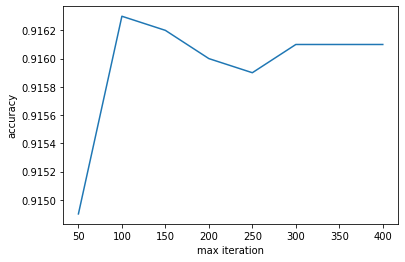

In [30]:
plt.plot(iter, accuracy)
plt.xlabel('max iteration')
plt.ylabel('accuracy')
plt.show()

So there's no need for complete convergence, we may use the default 100 max_iter. Next find the best regularization parameter. Note: the following approach is technically not correct because we did standardization on the whole training set first, so the test fold will contain information from the training fold in cross validation, but we want them to have as little correlation as possible. A more rigorous approach will be introduced later when using svm with the help of pipeline.

In [31]:
%%capture
lr_clf_cv = LogisticRegressionCV(random_state=42)
lr_clf_cv.fit(X_train_shrunken_scaled, y_train)

In [32]:
lr_clf_cv.C_

array([21.5443469, 21.5443469, 21.5443469, 21.5443469, 21.5443469,
       21.5443469, 21.5443469, 21.5443469, 21.5443469, 21.5443469])

The best regularization parameter is found, now use all the data to build logistic regression again.

In [33]:
lr_clf = LogisticRegression(max_iter = 1000, C = lr_clf_cv.C_[0])
lr_clf.fit(X_train_shrunken_scaled, y_train)
lr_clf_accuracy = lr_clf.score(X_test_shrunken_scaled, y_test)
print(lr_clf_accuracy)

0.9157


Next try svm. It works well when the number of features are larger than that of training examples, like spam fliter case, let's see how it performs. Note that here we used pipeline, which combine the process of standardization and cross validation. Now the test fold and train fold will be standardized separately. However, the following code takes an extremely long time, if you have a better hardware you can try it, but here I'll simply build a default setting SVM for convenience.

In [11]:
# steps = [('scaler', StandardScaler()), ('svm', SVC(kernel='rbf'))]
# pipeline = Pipeline(steps)
# parameters = {'svm__C':[0.1,1,10], 'svm__gamma':[0.01, 0.1,1]}
# svm_gscv = GridSearchCV(pipeline, param_grid=parameters, cv=5)
# svm_gscv.fit(X_train_shrunken, y_train)
# svm_gscv.best_params_

In [34]:
svm = SVC(kernel = 'rbf')
svm.fit(X_train_shrunken_scaled, y_train)
svm_accuracy = svm.score(X_test_shrunken_scaled, y_test)
print(svm_accuracy)

0.9622


Next, draw the confusion matrix for each model

In [35]:
def cm(name, X):
    preds = name.predict(X)
    cm = metrics.confusion_matrix(y_test, preds)
    return cm

cm_list = []
cm_list.append(cm(knn, X_test_shrunken))
cm_list.append(cm(lr_clf, X_test_shrunken_scaled))
cm_list.append(cm(svm, X_test_shrunken_scaled))


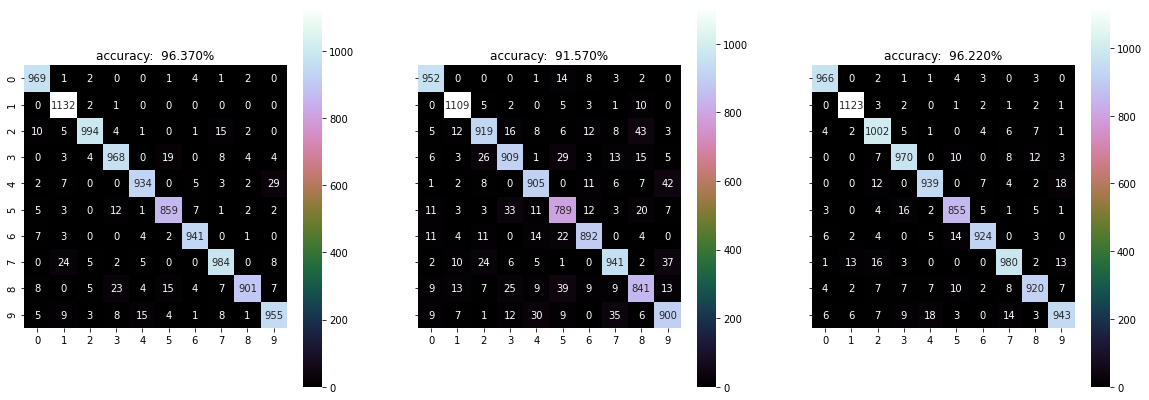

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(20,7), sharey=True)
accuracy_list = [knn_accuracy, lr_clf_accuracy, svm_accuracy]
for i in range(3):
    sn.heatmap(cm_list[i], annot=True, fmt=".0f", cmap = 'cubehelix', square = True, ax = axes[i])
    axes[i].set_title(f'accuracy:  {accuracy_list[i]:.3%}')

A rough look tells us that all models performs relatively bad on digit 9. Each model has it strength in certain numbers.

Take a look at the first 8 wrong predictions in knn.

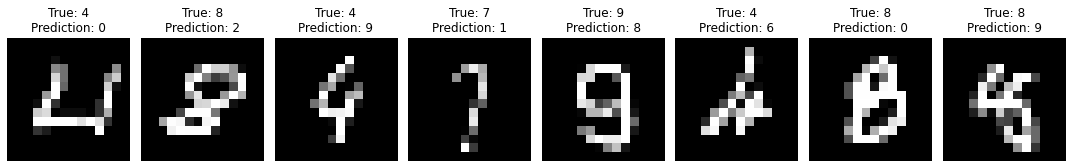

In [37]:
wrong_idx = []
preds = knn.predict(X_test_shrunken)
for i in range(len(preds)):
    if preds[i] != y_test[i]:
        wrong_idx.append(i)

wrong_preds = X_test_shrunken[wrong_idx]

fig = plt.figure(figsize=(15, 10))
for i in range(8):
    fig.add_subplot(1, 8, i+1)
    plt.axis('off')
    plt.imshow(np.reshape(wrong_preds[i], (14, 14)), cmap = 'gray') # convert the vector back to matrix
    plt.title(f'True: {y_test[wrong_idx[i]]}\nPrediction: {preds[wrong_idx[i]]}')
plt.tight_layout()

I totally understand why they are recognized wrongly. The writings are too ambiguous, human eyes may even make mistakes here, let alone the machine learning algorithms.

The next step is of course make a interative UI that allow us to draw a digit and test the power of these models with our hand-written digits.

In [38]:
display_width = 250
display_height = 250
white = (255,255,255)
black = (0,0,0)
radius = 10 

def predict(name, gameDisplay):
    img_string = pygame.image.tostring(gameDisplay, 'RGB')
    img = Image.frombytes("RGB", (display_width, display_height), img_string)
    img = resizeimage.resize_cover(img, [14,14])
    img_vector = np.asarray(img)
    img_vector = cv2.cvtColor(img_vector, cv2.COLOR_RGB2GRAY)
    pred = name.predict(np.reshape(img_vector, (1,-1)))
    return pred

def display(pred, gameDisplay):
    gameDisplay.fill(black)
    font = pygame.font.Font('freesansbold.ttf', 32)
    phrase = choice(['Maybe', 'I guess', 'Could it be', 'Looks like', ''])
    text = font.render(f'{phrase} {pred[0]}?', True, white)
    gameDisplay.blit(text, ((display_width - text.get_width())//2, (display_height - text.get_height())//2))
    pygame.display.flip()

def recognize(name):
    tick = tock = 0
    start = False

    pygame.init()
    gameDisplay = pygame.display.set_mode((display_width,display_height))
    running = True

    while running:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
            elif event.type == KEYDOWN:
                if event.key == K_ESCAPE:
                    running = False

        tock = time.process_time()
        if pygame.mouse.get_pressed()[0]:
            start = True
            pos = pygame.mouse.get_pos()
            pygame.draw.circle(gameDisplay,white,pos,radius, 10)
            pygame.display.flip()
            tick = time.process_time()

        if tock - tick > 2 and start:
            pred = predict(name, gameDisplay)
            display(pred, gameDisplay)

            time.sleep(1)
            gameDisplay.fill(black)
            pygame.display.flip()
            tick = tock = 0
            start = False
            continue
    pygame.quit()

In [41]:
recognize(knn)
# recognize(lr_clf) # try it
#recognize(svm)

This digit recognition project ends here, but an intereting idea comes to my mind. 

Here each data is a vector whose entry means the color of a pixel, can we think of a man's life like this? Each man's life is a data, it can be viewed as a vector composed by the thing he does in every second of his life. We can quantify the "thing" into a number using a certain standard, just as the standard for mapping colors. So we can essentially vectorize a man. To this point, we can then use machine learning algorithm to analyze this man, make prediction to his future.

You can refer to my other ML-ideas repo for more non-sense.